# Importing the libraries and functions from another files

# Downloading the dataset

In [19]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dnkumars/cybersecurity-intrusion-detection-dataset")

# print("Path to dataset files:", path)


In [9]:
data = pd.read_csv("airlines2.csv")


In [10]:
data


,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,target
0,4,269,253,135,3,15,205,1
1,14,1558,217,60,3,15,222,1
2,1,2400,154,80,3,20,165,1
3,1,2466,253,80,3,20,195,1
4,2,108,14,252,3,30,202,0
...,...,...,...,...,...,...,...,...
539378,4,178,203,264,5,1439,326,0
539379,8,398,252,16,5,1439,305,0
539380,8,609,253,184,5,1439,255,0
539381,13,78,128,253,5,1439,313,1


# Preprocessing the dataset

In [11]:
X = data.drop(columns=["target"])

# Convert categorical columns to numeric (one-hot encoding)
X = pd.get_dummies(X)

# Convert to NumPy array
X = X.values


In [12]:
X


array([[   4,  269,  253, ...,    3,   15,  205],
       [  14, 1558,  217, ...,    3,   15,  222],
       [   1, 2400,  154, ...,    3,   20,  165],
       ...,
       [   8,  609,  253, ...,    5, 1439,  255],
       [  13,   78,  128, ...,    5, 1439,  313],
       [  14, 1442,  154, ...,    5, 1439,  301]])

# ShapeDD Algorithm

In [13]:
# Inputs:

# X: The data (or an array of indices).
# chunk_size: The size of each batch (window).
# overlap: How much each batch overlaps with the previous one (default is 100).
# How it works:

# Calculates shift, the step size between the start of each batch (shift = chunk_size - overlap).
# Iterates over the data, creating batches of size chunk_size that overlap by overlap samples.
# Each batch is a slice of X from i*shift to min(chunk_size + i*shift, X.shape[0]).
# Appends each batch to the result list res.
# Returns:
# A list of batches (each batch is a slice of X), covering the data with the specified overlap.

def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [7]:
def run_shape_on_real_data(X, chunk_size):
    t0 = time.time()
    shp = shape(X, 50, chunk_size, 2500)  # Do NOT slice [:,2], keep all columns
    t1 = time.time()
    res = []
    batches = batch(np.arange(X.shape[0]), chunk_size=chunk_size)
    batch_count = len(batches)
    for b in batches:
        res.append({
            "method": "shape",
            "shape_stat_min": float("%.5f" % shp[b, 0].min()),
            "mmd_stat_min": float("%.5f" % shp[b, 1].min()),
            "p_value_min": float("%.5f" % shp[b, 2].min()),
            "chunk_size": chunk_size,
            "comp_time": (t1 - t0) / batch_count
        })
    return res


In [23]:
def run_exp(X, chunk_size):
    # X,y=gen_random(**dict([("dist",dist),("alt",alt),(task,value)  ,  ("length",750),("min_dist",10)]))
    
    t0 = time.time()
    shp = shape(X, 50,chunk_size, 2500)[:,2]
    t1 = time.time()
    
    res = []
    batches = batch(np.arange(X.shape[0]), chunk_size=chunk_size)
    batch_count = len(batches)
    for b in batches:
        x_ = X[b]
        drift_score = (y[b][None,:] != y[b][:,None]).sum()/( b.shape[0]*(b.shape[0]-1) )
        res += [{"drift_score":drift_score, "method":method, "estimate":estimate, "chunk_size": chunk_size, "comp_time": comp_time} for method,(comp_time,estimate) in 
               {
                   "shape":        ((t1-t0)/batch_count,float("%.5f"%shp[b].min()))
               }.items()]
    return res


In [2]:
def run_shapedd_streaming(X, window_size=1000, step_size=250, l1=50, n_perm=500):
    """
    Run ShapeDD in a streaming way over X using a sliding window.
    Returns a list of drift results aligned with the center of each window.
    """
    results = []
    positions = []
    
    for i in range(0, len(X) - window_size, step_size):
        window = X[i:i + window_size]
        
        # Run shape only on the window
        res = shape(window, l1=l1, l2=window_size, n_perm=n_perm)
        
        # Record drift decision at the center of the window
        drift_flags = res[:, 2]
        results.append(int(drift_flags.min()))
        positions.append(i + window_size // 2)

    return np.array(positions), np.array(results)


In [ ]:
X = X[:10000]  # Use only the first 1000 rows for testing
res = []
res = run_shape_on_real_data(X, 100)


In [49]:
res


[{'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 0.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 0.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size':

In [51]:
res2 = run_exp(X, 1000)
res2


[{'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 1.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772}]

In [50]:
# Extracting drift_score values
drift_scores = [entry['shape_stat_min'] for entry in res]
print("Drift scores:", drift_scores)


Drift scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
positions, drift_results = run_shapedd_streaming(X, window_size=1000, step_size=500, l1=50, n_perm=250)


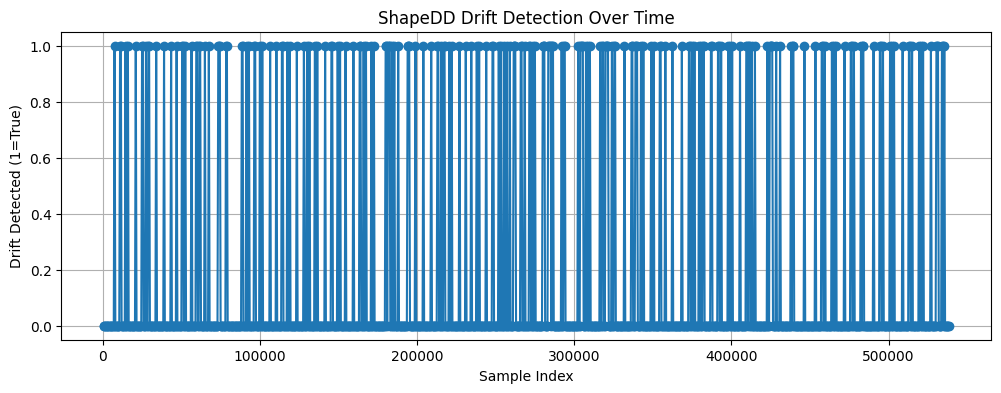

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(positions, drift_results, marker='o', linestyle='-')
plt.title("ShapeDD Drift Detection Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Drift Detected (1=True)")
plt.grid(True)
plt.show()


In [19]:
from sklearn.datasets import load_iris, load_breast_cancer


# Load the breast cancer dataset
breast_cancer = load_breast_cancer(as_frame=True)
bc_data = breast_cancer.frame
X_bc = bc_data.drop(columns=["target"])


In [21]:
bc_data


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [27]:
positions, drift_results = run_shapedd_streaming(X_bc, window_size=200, step_size=25, l1=50, n_perm=250)


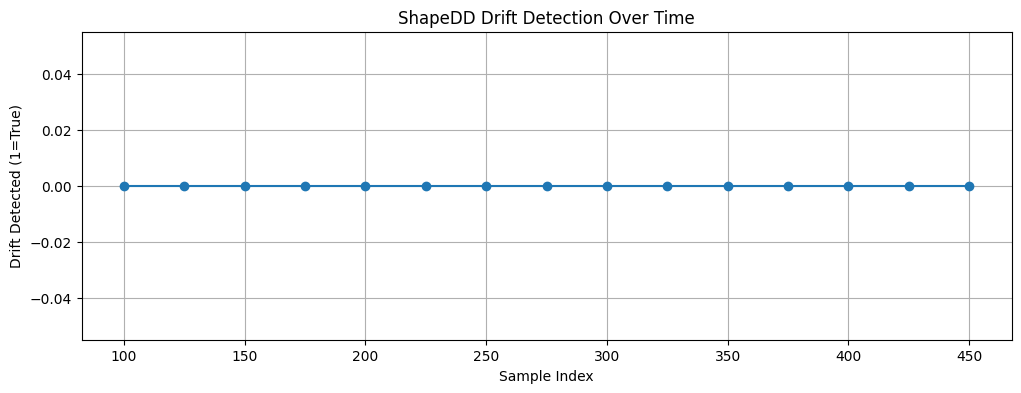

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(positions, drift_results, marker='o', linestyle='-')
plt.title("ShapeDD Drift Detection Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Drift Detected (1=True)")
plt.grid(True)
plt.show()


# Experiment with synthetic data

## Generating the dataset

In [ ]:
# To be improved
# X,y=gen_random(**dict([("dist",dist),("alt",alt),(task,value)  ,  ("length",750),("min_dist",10)]))


In [14]:
import numpy as np

# Generate synthetic data with 2 drifts, 3 features, and uniform distribution
# Generate synthetic data with drift
X, y = gen_random(number=2,  # number of change points
                 dims=5,     # number of dimensions
                 intens=0.5, # intensity of drift
                 dist="unif",# distribution type
                 alt=True,   # alternating drift
                 length=750) # length of sequence

print("X shape:", X.shape)        # (100, 3)
print("First 5 rows of X:\n", X[:5])
print("Drift indicator e:\n", y)


X shape: (750, 5)
First 5 rows of X:
 [[0.55932881 0.17718886 0.15106817 0.66251394 0.61294012]
 [0.3796942  0.94106612 0.88515828 0.96170322 0.01596591]
 [0.07291718 0.18235823 0.31255051 0.7847218  0.29937212]
 [0.64319493 0.49221494 0.02988912 0.52454483 0.87537666]
 [0.33143259 0.9199333  0.95700868 0.09201766 0.28335013]]
Drift indicator e:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [16]:
# Run drift detection experiment
# Run streaming shape drift detection
positions, drift_results = run_shapedd_streaming(X, 
                                              window_size=150,  # Increased from 100 to 150
                                              step_size=25,
                                              l1=50,
                                              n_perm=500)


In [18]:
import matplotlib.pyplot as plt


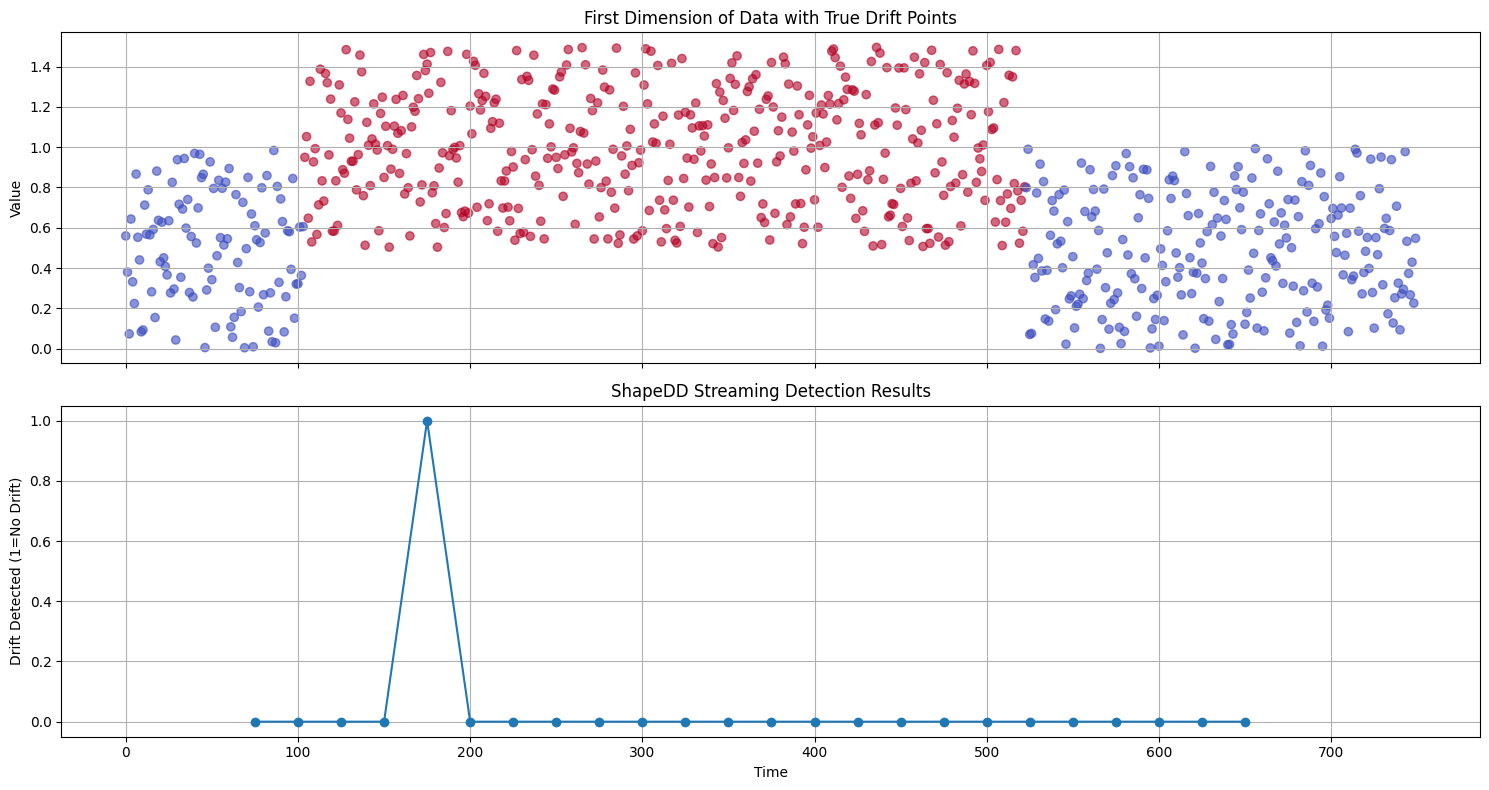


Comparison Statistics:
Number of true drift points: 2
Number of detected drift points: 2

Detected change positions: [150 175]
True drift positions: [103 522]


In [19]:
# Plot both the original data and drift detection results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot the data and true drift points
ax1.scatter(range(len(X)), X[:, 0], c=y, cmap='coolwarm', alpha=0.6)
ax1.set_title('First Dimension of Data with True Drift Points')
ax1.set_ylabel('Value')
ax1.grid(True)

# Plot the detected drift points
ax2.plot(positions, drift_results, marker='o', linestyle='-', label='Detected Drift')
ax2.set_title('ShapeDD Streaming Detection Results')
ax2.set_xlabel('Time')
ax2.set_ylabel('Drift Detected (1=No Drift)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nComparison Statistics:")
print(f"Number of true drift points: {sum(np.diff(y) != 0)}")
print(f"Number of detected drift points: {sum(np.diff(drift_results) != 0)}")

# Find positions where drift was detected (where drift_results changes)
detected_changes = positions[np.where(np.diff(drift_results) != 0)[0]]
print("\nDetected change positions:", detected_changes)

# Find true drift positions
true_changes = np.where(np.diff(y) != 0)[0]
print("True drift positions:", true_changes)


ShapeDD Drift Detection Results:
Batch 1 (samples 0-100):
  Method: shape
  P-value: 1.0
  Detected drift: No
  True drift: No
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 2 (samples 100-200):
  Method: shape
  P-value: 0.0
  Detected drift: Yes
  True drift: Yes
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 3 (samples 200-300):
  Method: shape
  P-value: 0.1452
  Detected drift: No
  True drift: No
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 4 (samples 300-400):
  Method: shape
  P-value: 0.0556
  Detected drift: No
  True drift: No
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 5 (samples 400-500):
  Method: shape
  P-value: 1.0
  Detected drift: No
  True drift: No
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 6 (samples 500-600):
  Method: shape
  P-value: 0.0
  Detected drift: Yes
  True drift: Yes
  Computation time: 0.0264 seconds
  Match: ✓
---
Batch 7 (samples 600-700):
  Method: shape
  P-value: 0.2824
  Detected drift: No
 

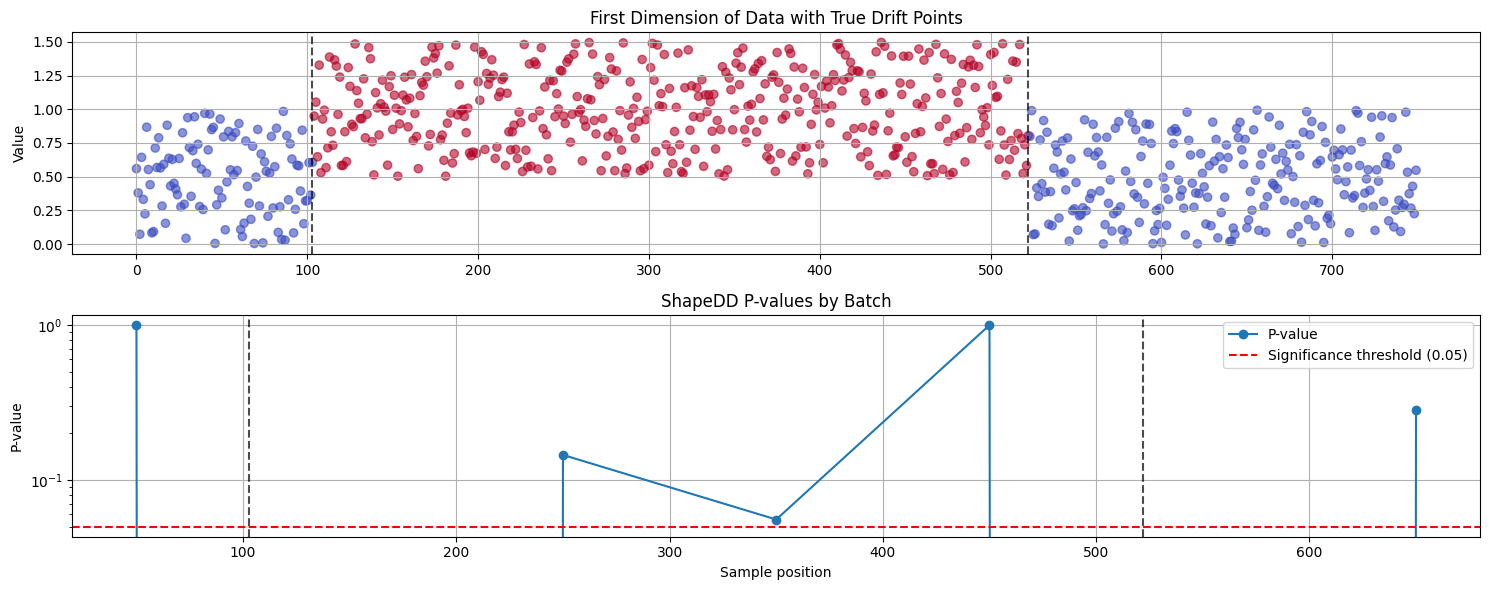


Accuracy: 100.00% (7/7 batches correctly classified)


In [24]:
results = run_exp(X, chunk_size=100)

# Print results
print("ShapeDD Drift Detection Results:")
for i, res in enumerate(results):
    batch_start = i * (100 - 0)  # Assuming no overlap
    batch_end = min(batch_start + 100, len(X))
    batch_center = (batch_start + batch_end) // 2
    
    # Get the true drift in this batch
    true_drift = "Yes" if np.any(np.diff(y[batch_start:batch_end]) != 0) else "No"
    
    # The p-value estimate - smaller means more likely to have drift
    # For shape, p-value < 0.05 typically indicates drift
    detected_drift = "Yes" if float(res['estimate']) < 0.05 else "No"
    
    print(f"Batch {i+1} (samples {batch_start}-{batch_end}):")
    print(f"  Method: {res['method']}")
    print(f"  P-value: {res['estimate']}")
    print(f"  Detected drift: {detected_drift}")
    print(f"  True drift: {true_drift}")
    print(f"  Computation time: {res['comp_time']:.4f} seconds")
    print(f"  Match: {'✓' if detected_drift == true_drift else '✗'}")
    print("---")

# Find positions where true drift occurs
true_drift_positions = np.where(np.diff(y) != 0)[0]
print("\nTrue drift occurs at positions:", true_drift_positions)

# Visualize
plt.figure(figsize=(15, 6))

# Plot values with color showing the true drift
plt.subplot(211)
plt.scatter(range(len(X)), X[:, 0], c=y, cmap='coolwarm', alpha=0.6)
for pos in true_drift_positions:
    plt.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
plt.title('First Dimension of Data with True Drift Points')
plt.ylabel('Value')
plt.grid(True)

# Plot batch-wise p-values
plt.subplot(212)
batch_centers = [i * (100 - 0) + 50 for i in range(len(results))]
batch_centers = [min(c, len(X)-1) for c in batch_centers]  # Ensure within bounds
p_values = [float(res['estimate']) for res in results]

plt.plot(batch_centers, p_values, 'o-', label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance threshold (0.05)')
for pos in true_drift_positions:
    plt.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
plt.title('ShapeDD P-values by Batch')
plt.xlabel('Sample position')
plt.ylabel('P-value')
plt.yscale('log')  # Log scale makes p-values easier to read
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate accuracy statistics
correct_detections = 0
total_batches = len(results)

for i, res in enumerate(results):
    batch_start = i * (100 - 0)  # Assuming no overlap
    batch_end = min(batch_start + 100, len(X))
    
    true_drift = np.any(np.diff(y[batch_start:batch_end]) != 0)
    detected_drift = float(res['estimate']) < 0.05
    
    if (true_drift and detected_drift) or (not true_drift and not detected_drift):
        correct_detections += 1

accuracy = correct_detections / total_batches * 100
print(f"\nAccuracy: {accuracy:.2f}% ({correct_detections}/{total_batches} batches correctly classified)")


ShapeDD Drift Detection Results with Drift Scores:
Batch 1 (samples 0-99):
  Method: shape
  P-value: 1.0
  Detected drift: No
  Drift score: 0.000000
  True drift: No
  Computation time: 0.0294 seconds
  Match: ✓
---
Batch 2 (samples 100-199):
  Method: shape
  P-value: 0.3392
  Detected drift: No
  Drift score: 0.000000
  True drift: No
  Computation time: 0.0294 seconds
  Match: ✓
---
Batch 3 (samples 200-299):
  Method: shape
  P-value: 0.0
  Detected drift: Yes
  Drift score: 0.197778
  True drift: Yes
  Computation time: 0.0294 seconds
  Match: ✓
---
Batch 4 (samples 300-399):
  Method: shape
  P-value: 1.0
  Detected drift: No
  Drift score: 0.000000
  True drift: No
  Computation time: 0.0294 seconds
  Match: ✓
---
Batch 5 (samples 400-499):
  Method: shape
  P-value: 0.172
  Detected drift: No
  Drift score: 0.000000
  True drift: No
  Computation time: 0.0294 seconds
  Match: ✓
---
Batch 6 (samples 500-599):
  Method: shape
  P-value: 0.0
  Detected drift: Yes
  Drift score: 

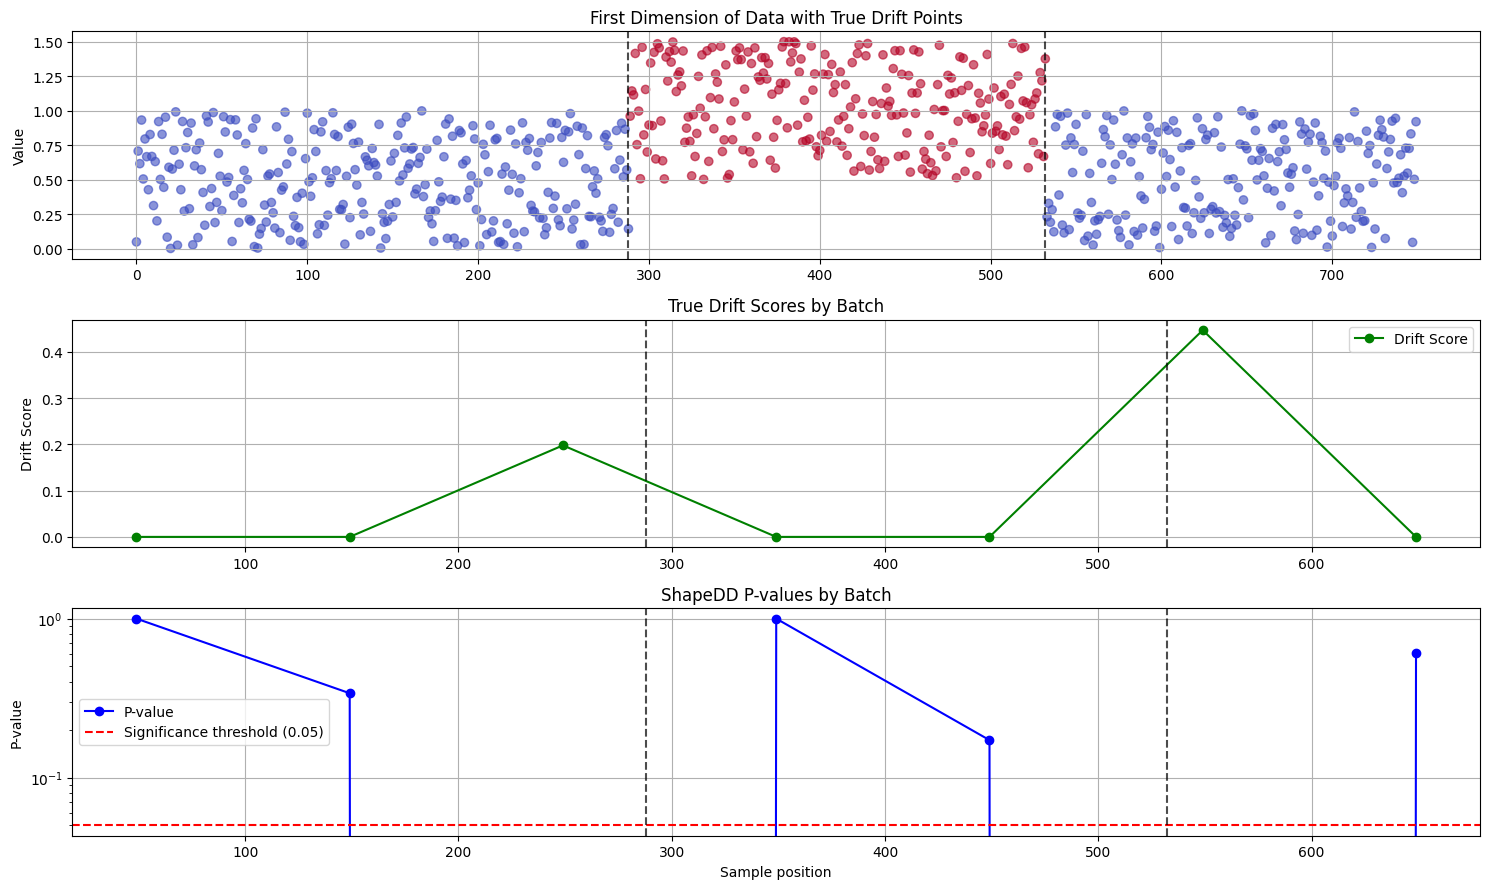


Accuracy: 100.00% (7/7 batches correctly classified)

Correlation between -log(p-value) and drift score:
Pearson correlation: 0.9081 (p=0.0047)
Spearman correlation: 0.7938 (p=0.0331)


In [25]:
# Generate synthetic data with known drift points
X, y = gen_random(number=2,  # number of change points
                 dims=5,     # number of dimensions
                 intens=0.5, # intensity of drift
                 dist="unif",# distribution type
                 alt=True,   # alternating drift
                 length=750) # length of sequence

# Calculate drift scores for each batch
def calculate_drift_scores(y, chunk_size, overlap=0):
    batches = batch(np.arange(y.shape[0]), chunk_size=chunk_size, overlap=overlap)
    drift_scores = []
    
    for b in batches:
        # Original drift score calculation from the commented code in run_exp
        drift_score = (y[b][None,:] != y[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))
        drift_scores.append(drift_score)
    
    return batches, drift_scores

batches, drift_scores = calculate_drift_scores(y, chunk_size=100)

# Run drift detection using run_exp
results = run_exp(X, chunk_size=100)

# Print results with drift scores
print("ShapeDD Drift Detection Results with Drift Scores:")
for i, (batch_indices, res, drift_score) in enumerate(zip(batches, results, drift_scores)):
    batch_start = min(batch_indices)
    batch_end = max(batch_indices)
    batch_center = (batch_start + batch_end) // 2
    
    # The p-value estimate - smaller means more likely to have drift
    # For shape, p-value < 0.05 typically indicates drift
    detected_drift = "Yes" if float(res['estimate']) < 0.05 else "No"
    
    # True drift based on drift score - any non-zero drift score indicates drift
    true_drift = "Yes" if drift_score > 0 else "No"
    
    print(f"Batch {i+1} (samples {batch_start}-{batch_end}):")
    print(f"  Method: {res['method']}")
    print(f"  P-value: {res['estimate']}")
    print(f"  Detected drift: {detected_drift}")
    print(f"  Drift score: {drift_score:.6f}")
    print(f"  True drift: {true_drift}")
    print(f"  Computation time: {res['comp_time']:.4f} seconds")
    print(f"  Match: {'✓' if detected_drift == true_drift else '✗'}")
    print("---")

# Find positions where true drift occurs
true_drift_positions = np.where(np.diff(y) != 0)[0]
print("\nTrue drift occurs at positions:", true_drift_positions)

# Visualize with drift scores
plt.figure(figsize=(15, 9))

# Plot values with color showing the true drift
plt.subplot(311)
plt.scatter(range(len(X)), X[:, 0], c=y, cmap='coolwarm', alpha=0.6)
for pos in true_drift_positions:
    plt.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
plt.title('First Dimension of Data with True Drift Points')
plt.ylabel('Value')
plt.grid(True)

# Plot batch-wise drift scores
plt.subplot(312)
batch_centers = [(min(b) + max(b)) // 2 for b in batches]
plt.plot(batch_centers, drift_scores, 'o-', color='green', label='Drift Score')
plt.title('True Drift Scores by Batch')
plt.ylabel('Drift Score')
for pos in true_drift_positions:
    plt.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.grid(True)

# Plot batch-wise p-values
plt.subplot(313)
p_values = [float(res['estimate']) for res in results]

plt.plot(batch_centers, p_values, 'o-', color='blue', label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance threshold (0.05)')
for pos in true_drift_positions:
    plt.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
plt.title('ShapeDD P-values by Batch')
plt.xlabel('Sample position')
plt.ylabel('P-value')
plt.yscale('log')  # Log scale makes p-values easier to read
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate accuracy statistics based on drift score
correct_detections = 0
total_batches = len(results)

for res, drift_score in zip(results, drift_scores):
    detected_drift = float(res['estimate']) < 0.05
    true_drift = drift_score > 0
    
    if (true_drift and detected_drift) or (not true_drift and not detected_drift):
        correct_detections += 1

accuracy = correct_detections / total_batches * 100
print(f"\nAccuracy: {accuracy:.2f}% ({correct_detections}/{total_batches} batches correctly classified)")

# Calculate correlation between p-values and drift scores
from scipy.stats import pearsonr, spearmanr

# Convert p-values for correlation (lower p-value = higher certainty of drift)
# We use -log(p) to make this relationship more linear
import numpy as np
log_p_values = -np.log10([max(float(res['estimate']), 1e-10) for res in results])

pearson_corr, pearson_p = pearsonr(log_p_values, drift_scores)
spearman_corr, spearman_p = spearmanr(log_p_values, drift_scores)

print(f"\nCorrelation between -log(p-value) and drift score:")
print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")


In [35]:
def run_exp_improved(X, y=None, chunk_size=100, overlap=0, l1=50, n_perm=2500):
    """
    Improved version of run_exp that incorporates drift score calculation and detailed metrics.
    """
    import time
    import numpy as np
    import pandas as pd
    
    # Time the shape computation
    t0 = time.time()
    try:
        shp = shape(X, l1, chunk_size, n_perm)
        t1 = time.time()
        shape_computation_time = t1 - t0
    except Exception as e:
        return []
    
    # Generate batches
    batches = batch(np.arange(X.shape[0]), chunk_size=chunk_size, overlap=overlap)
    batch_count = len(batches)
    
    res = []
    for i, b in enumerate(batches):
        batch_data = X[b]
        
        # Shape results for this batch
        shape_stat_min = float("%.5f" % shp[b, 0].min()) if shp.shape[1] > 2 else None
        mmd_stat_min = float("%.5f" % shp[b, 1].min()) if shp.shape[1] > 2 else None 
        p_value_min = float("%.5f" % shp[b, 2].min())
        
        # Calculate drift score if ground truth is available
        drift_score = None
        if y is not None:
            drift_score = (y[b][None,:] != y[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))
            drift_score = float("%.5f" % drift_score)
        
        # Create result dictionary
        result = {
            "batch_id": i,
            "batch_start": min(b),
            "batch_end": max(b),
            "method": "shape",
            "shape_stat_min": shape_stat_min,
            "mmd_stat_min": mmd_stat_min, 
            "p_value": p_value_min,
            "comp_time": shape_computation_time / batch_count,
            "chunk_size": chunk_size,
            "drift_detected": p_value_min < 0.05
        }
        
        # Add drift score if available
        if drift_score is not None:
            result["drift_score"] = drift_score
            result["true_drift"] = drift_score > 0
            
        res.append(result)
    
    # Convert to DataFrame for easier analysis
    res_df = pd.DataFrame(res)
    return res_df

def visualize_results(X, y, results_df):
    """
    Create a visualization of drift detection results.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    
    # Plot 1: Original data with true drift
    axes[0].scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                   cmap='coolwarm', alpha=0.6)
    axes[0].set_title('First Dimension with True Drift')
    axes[0].set_ylabel('Value')
    axes[0].grid(True)
    
    # Plot 2: Drift scores (if available)
    if 'drift_score' in results_df.columns:
        batch_centers = (results_df['batch_start'] + results_df['batch_end']) // 2
        axes[1].plot(batch_centers, results_df['drift_score'], 'o-g', label='Drift Score')
        axes[1].set_title('True Drift Score by Batch')
        axes[1].set_ylabel('Drift Score')
        axes[1].grid(True)
        axes[1].legend()
    
    # Plot 3: P-values
    batch_centers = (results_df['batch_start'] + results_df['batch_end']) // 2
    axes[2].plot(batch_centers, results_df['p_value'], 'o-b', label='P-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('ShapeDD P-values by Batch')
    axes[2].set_xlabel('Sample Position')
    axes[2].set_ylabel('P-value')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    axes[2].legend()
    
    # Add true drift change points if available
    if y is not None:
        true_drift_positions = np.where(np.diff(y) != 0)[0]
        for ax in axes:
            for pos in true_drift_positions:
                ax.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


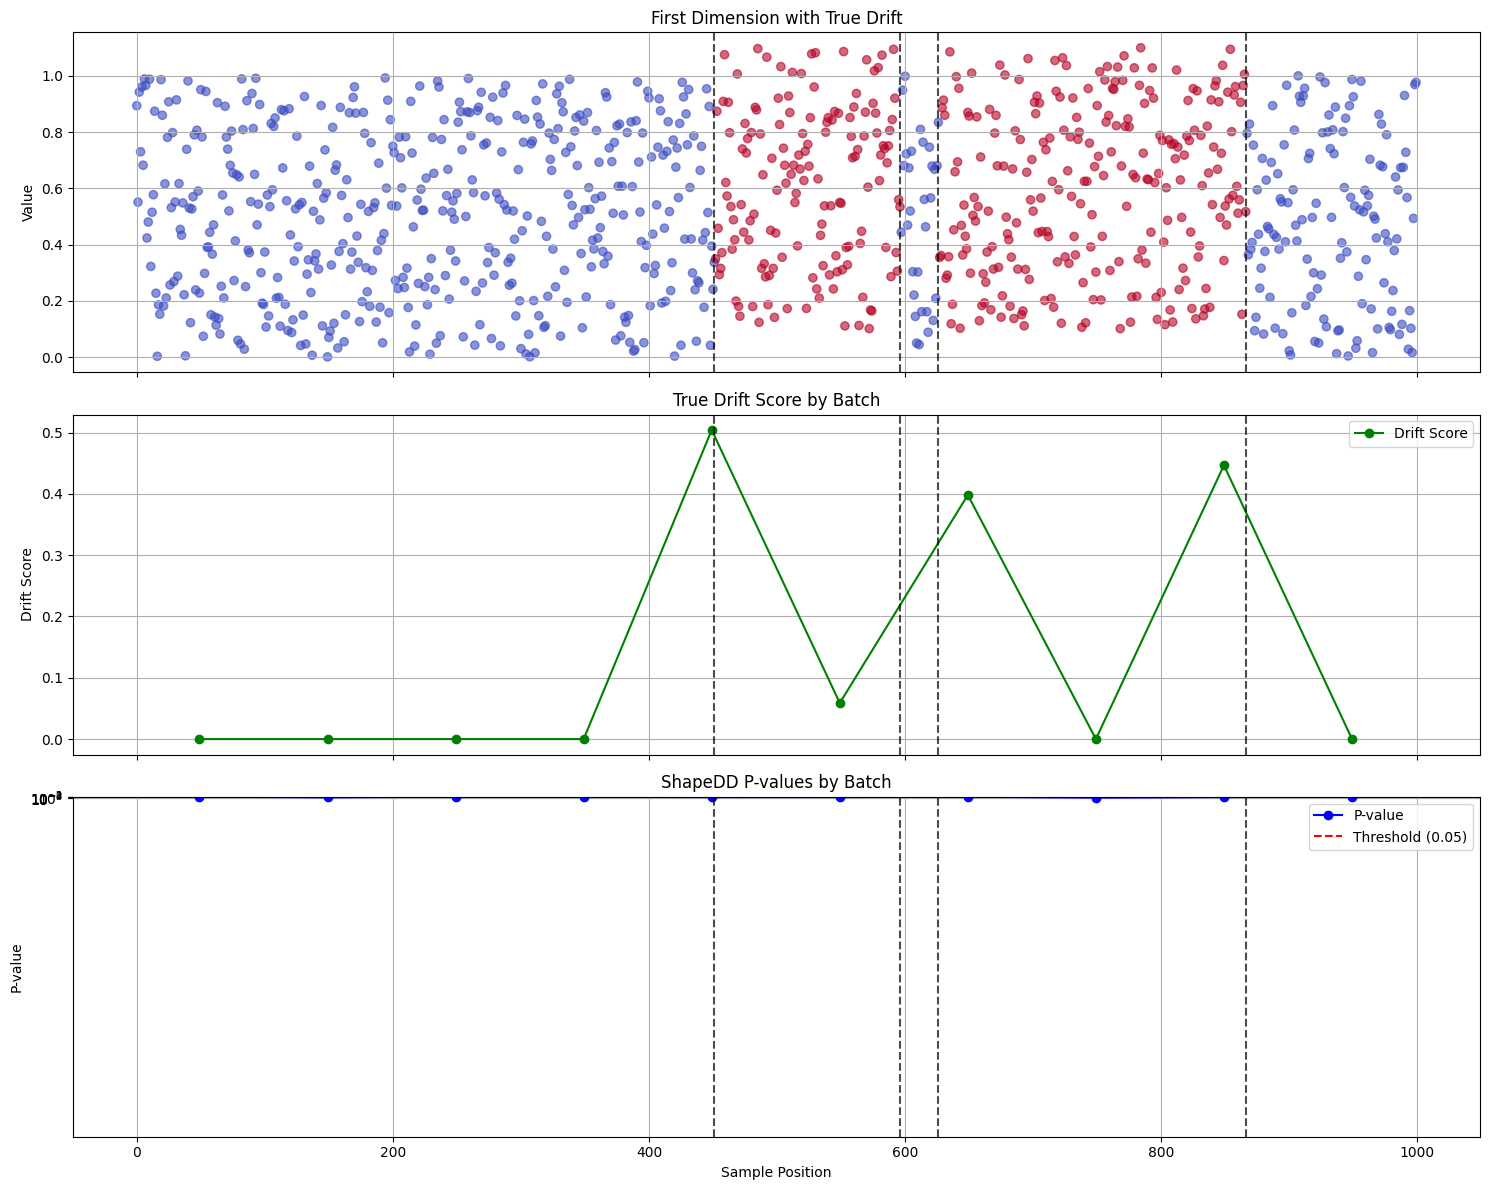

In [37]:
# Generate or load data
X, y = gen_random(number=4, dims=5, intens=0.1, dist="unif", alt=True, length=1000)

# Run analysis
results_df = run_exp_improved(X, y, chunk_size=100, overlap=0)

# Visualize
visualize_results(X, y, results_df)


# Final Improvement

## Algorithm

### Importing the libraries

In [17]:
# Importing necessary libraries
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score as roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel
from shape_dd import shape, shape_modified
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import multiprocessing
from multiprocessing.pool import Pool
from tqdm import tqdm
import os
import random
import time
from gen_data import gen_random



### Generating the data

In [18]:
# Generate synthetic data with known drift points
X, y = gen_random(number=10,  # number of change points
                 dims=2,     # number of dimensions
                 intens=0.5, # intensity of drift
                 dist="unif",# distribution type
                 alt=True,   # alternating drift
                 length=10000) # length of sequence


### Batch function to split the datas into batches to process

In [19]:
# Batch function to split the data into chunks with no overlap
def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [20]:
batches = batch(np.arange(X.shape[0]), chunk_size= 100)


### Ploting the generated data

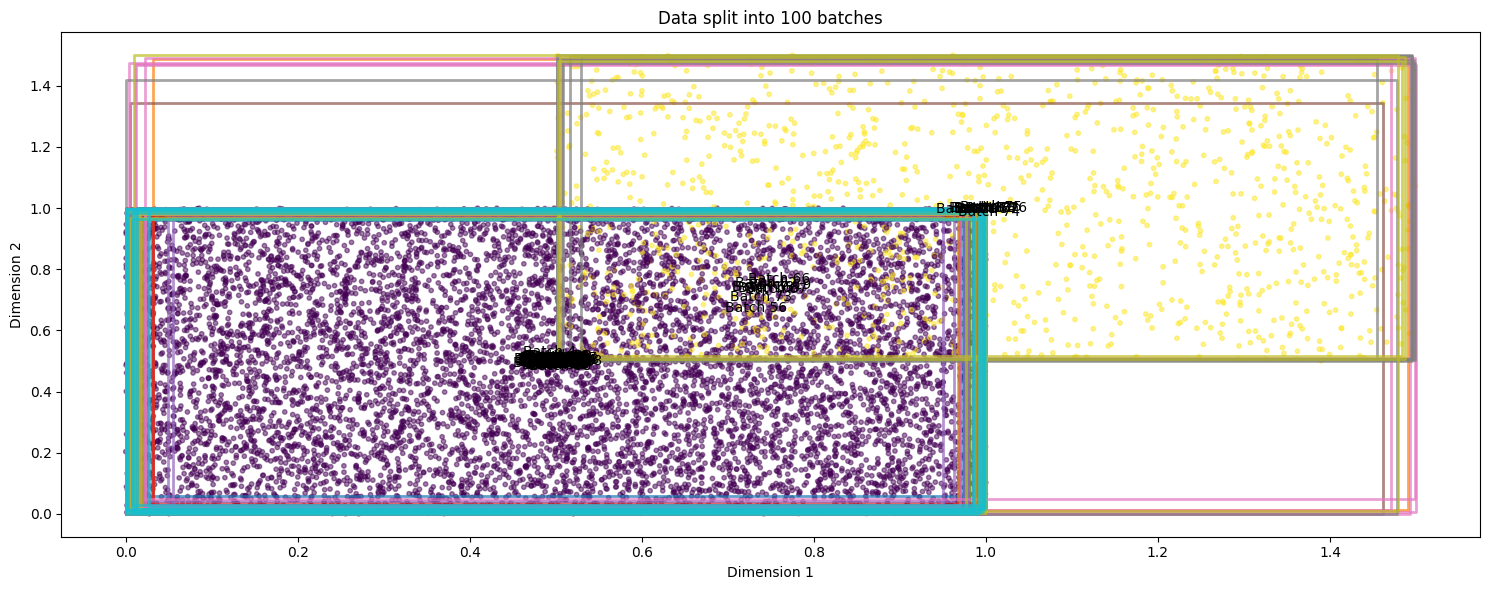

In [21]:
# Function to plot the batches
def plot_batches(X, batches, y=None):
    plt.figure(figsize=(15, 6))
    
    # Plot the first two dimensions of the data
    if X.shape[1] >= 2:
        plt.scatter(X[:, 0], X[:, 1], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches with different colors
        colors = plt.cm.tab10(np.linspace(0, 1, len(batches)))
        
        for i, batch_indices in enumerate(batches):
            batch_start = min(batch_indices)
            batch_end = max(batch_indices)
            
            # Draw rectangle around the batch
            x_min, x_max = X[batch_indices, 0].min(), X[batch_indices, 0].max()
            y_min, y_max = X[batch_indices, 1].min(), X[batch_indices, 1].max()
            
            plt.plot([x_min, x_max, x_max, x_min, x_min], 
                     [y_min, y_min, y_max, y_max, y_min], 
                     '-', color=colors[i], alpha=0.7, linewidth=2)
            
            # Add batch number
            plt.text((x_min + x_max)/2, (y_min + y_max)/2, f"Batch {i}", 
                    color='black', fontsize=10, ha='center', va='center')
    
    else:
        # If data has only one dimension, plot it against indices
        plt.scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches
        for i, batch_indices in enumerate(batches):
            plt.axvspan(min(batch_indices), max(batch_indices), 
                       alpha=0.2, color=plt.cm.tab10(i/10))
            plt.text(np.mean(batch_indices), plt.ylim()[0], f"Batch {i}", 
                    ha='center', va='bottom')
    
    plt.title(f"Data split into {len(batches)} batches")
    plt.xlabel("Dimension 1" if X.shape[1] >= 2 else "Index")
    plt.ylabel("Dimension 2" if X.shape[1] >= 2 else "Value")
    plt.tight_layout()
    plt.show()

# Plot the batches
plot_batches(X, batches, y)


### The Algorithm

In [22]:
# Calculate the shape statistic for the entire dataset
# l1 is the number of points to use for the shape statistic
# chunk_size is the number of points to use for the shape statistic
# n_perm is the number of permutations to use for the shape statistic
# shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)[:,2]
shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)
# Run the experiment


In [23]:
# Calculate the shape statistic for each batch
res = []
for b in batches:
    # Get the batch
    X_ = X[b]
    
    # Calculate the drift score for the batch
    drift_score = (y[b][None,:] != y[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))

    # Calculate the shape statistic for the batch
    shp_stat_min = float("%.5f" % shp[b, 0].min())
    mmd_stat_min = float("%.5f" % shp[b, 1].min())
    p_value_min = float("%.5f" % shp[b, 2].min())
    
    # Add the results to the list
    result = {
        # "batch_id": i,
        "batch_start": min(b),
        "batch_end": max(b),
        "drift_score": drift_score,
        "shape_stat_min": shp_stat_min,
        "mmd_stat_min": mmd_stat_min,
        "p_value": p_value_min
    }
    res.append(result)

# Convert the results to a DataFrame
res_df = pd.DataFrame(res)




In [36]:
def visualize_results(X, y, results_df):
    """
    Create a visualization of drift detection results.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Original data with true drift
    axes[0].scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                cmap='coolwarm', alpha=0.6)
    axes[0].set_title('First Dimension with True Drift')
    axes[0].set_ylabel('Value')
    axes[0].grid(True)
    
    # Plot 2: Drift scores (if available)
    if 'drift_score' in results_df.columns:
        batch_centers = (results_df['batch_start'] + results_df['batch_end'])
        axes[1].plot(batch_centers, results_df['drift_score'], 'o-g', label='Drift Score')
        axes[1].set_title('True Drift Score by Batch')
        axes[1].set_ylabel('Drift Score')
        axes[1].grid(True)
        axes[1].legend()
    

    # Plot 4: P-values
    batch_centers = (results_df['batch_start'] + results_df['batch_end'])
    axes[2].plot(batch_centers, results_df['p_value'], 'o-b', label='P-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('ShapeDD P-values by Batch')
    axes[2].set_xlabel('Sample Position')
    axes[2].set_ylabel('P-value')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    axes[2].legend()
    
    
    plt.tight_layout()
    plt.show()


### Visualize the result

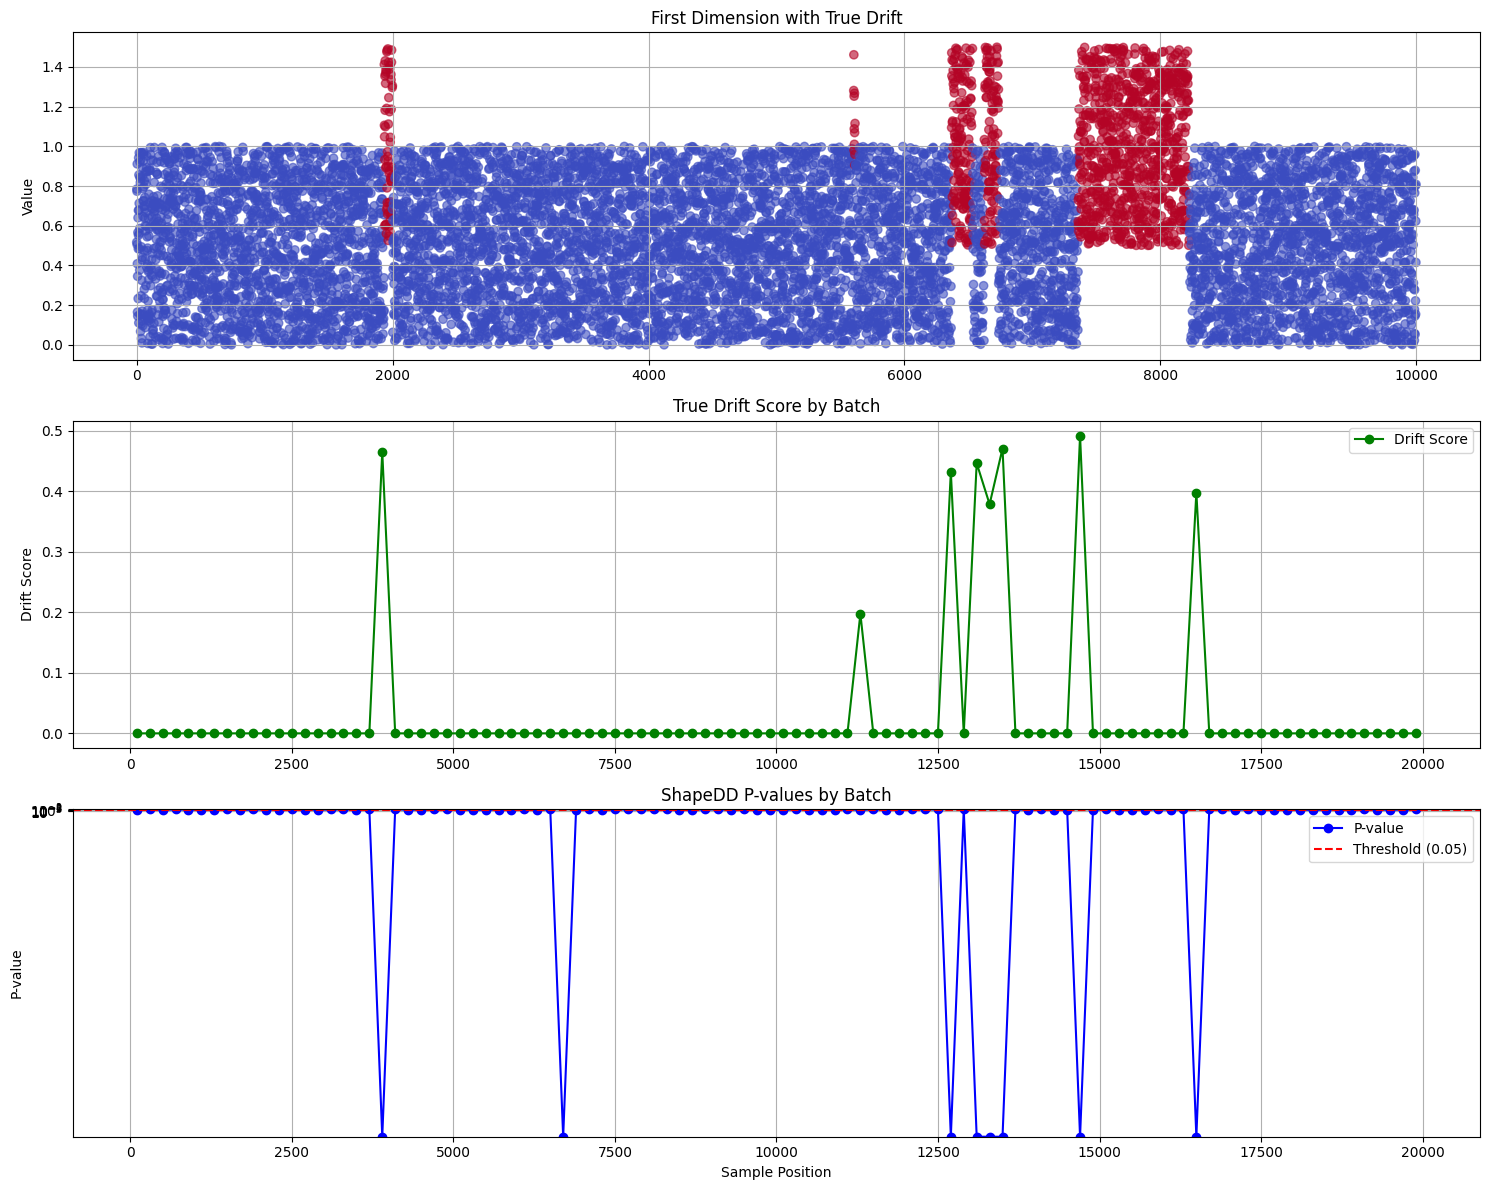

In [37]:
visualize_results(X, y, res_df)


# Modified version

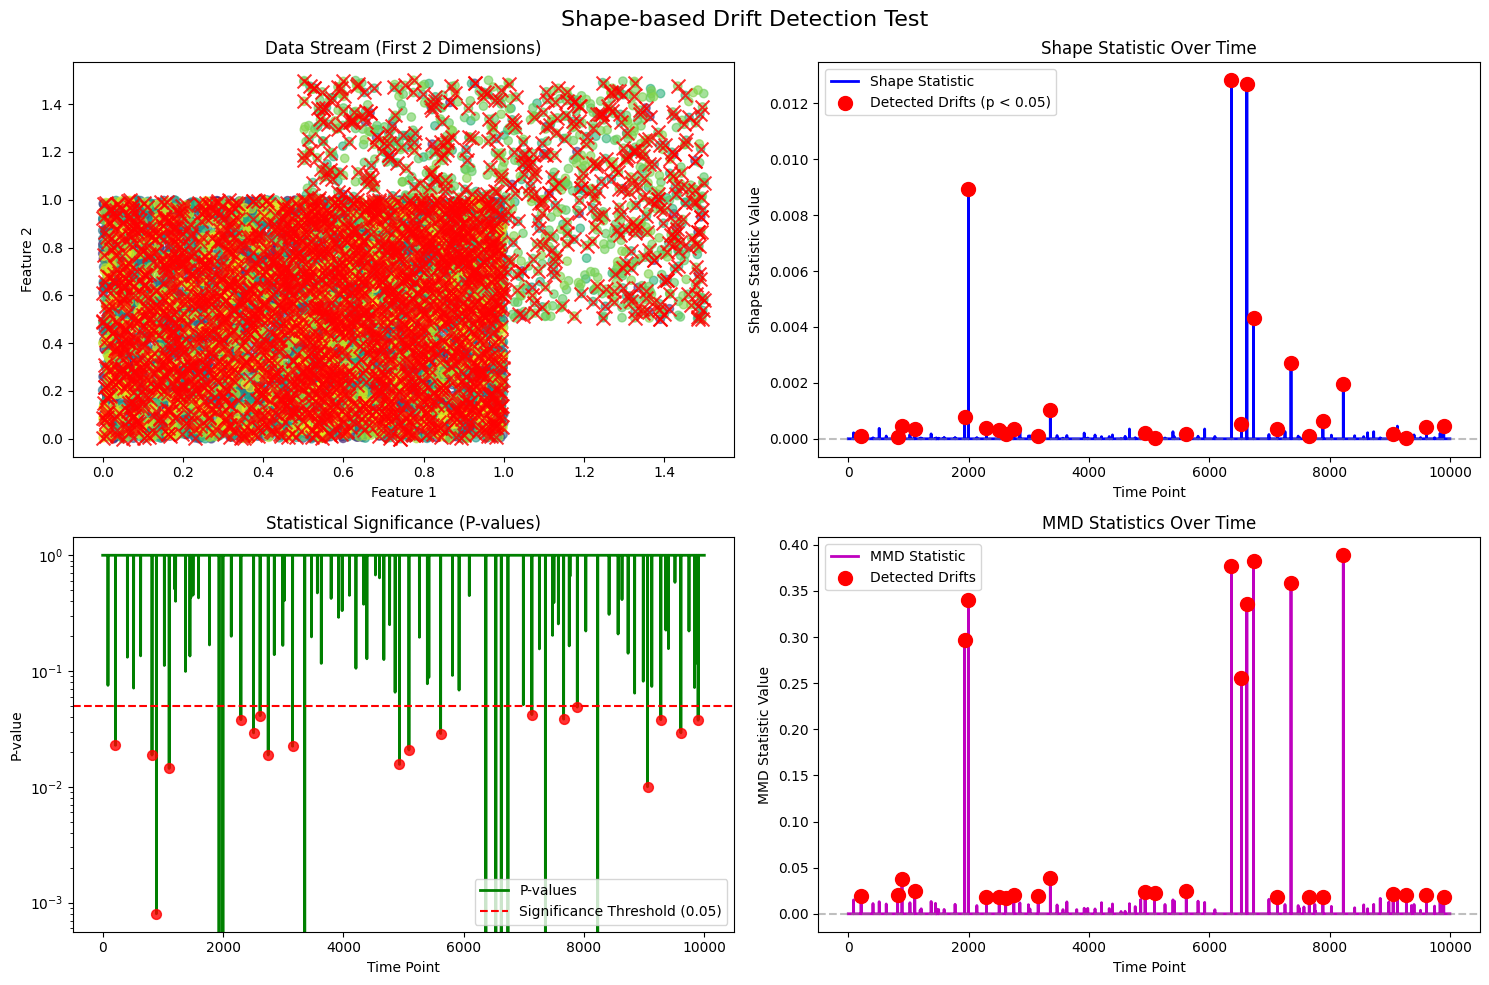


=== Drift Detection Summary ===
Number of significant drift points detected: 28
Drift positions: [np.int64(213), np.int64(820), np.int64(893), np.int64(1105), np.int64(1934), np.int64(1998), np.int64(2297), np.int64(2508), np.int64(2616), np.int64(2751), np.int64(3156), np.int64(3358), np.int64(4933), np.int64(5090), np.int64(5617), np.int64(6368), np.int64(6534), np.int64(6624), np.int64(6735), np.int64(7133), np.int64(7358), np.int64(7661), np.int64(7888), np.int64(8227), np.int64(9055), np.int64(9276), np.int64(9609), np.int64(9896)]
P-value threshold: 0.05
Drift 1: Position 213, Shape stat: 0.0001, MMD stat: 0.0190, P-value: 0.022800
Drift 2: Position 820, Shape stat: 0.0001, MMD stat: 0.0207, P-value: 0.018800
Drift 3: Position 893, Shape stat: 0.0005, MMD stat: 0.0372, P-value: 0.000800
Drift 4: Position 1105, Shape stat: 0.0004, MMD stat: 0.0250, P-value: 0.014400
Drift 5: Position 1934, Shape stat: 0.0008, MMD stat: 0.2968, P-value: 0.000000
Drift 6: Position 1998, Shape stat:

In [26]:
result = shape_modified(X, l1 = 50, l2 = 100, n_perm = 2500, 
                          plot=True, 
                          p_threshold=0.05,
                          title="Shape-based Drift Detection Test")
